# Part III - facies classification using ssGMM

* Part I  - estimating missing log values
* Part II - testing ssGMM
* **Part III - facies classification using ssGMM**

**Author: Michael W. Dunham**

**Date: October 25, 2019**

This Jupyter notebook is Part III in a series that focuses on applying ssGMM (semi-supervised method), and GNB and XGBoost (supervised methods) to the well log dataset. We begin by first loading the complete dataset from Part I, and then we split the data according the same scheme in Part II. Next, we establish the training and testing datasets, where 1 well (KIMZEY) is used for training and the remaining 9 wells are used for testing. This establishes the data preparation for the classification task.

We then train the supervised methods, GNB and XGBoost, and apply/evaluate their models on the testing data. A function for GNB is contained in sciki-learn, but XGBoost is an external piece of software that must be downloaded (see https://xgboost.readthedocs.io/en/latest/build.html). Model selection for XGBoost can be performed using the standard model selection approach that only uses the cross-validation means, or the SMSD approach discussed in the paper that simultaneously uses the cross-validation means and standard deviations to select a model. The same is true for the subseqent model selection procedure for ssGMM. The model selection parameters for XGB and ssGMM are set to achieve the best recovered models for each as depicted in the paper. The final stage of this notebook reproduces the figures necessary for interpretting these results, which correspond to confusion matrices, well section viewers, and computing accuracies on a per-well basis.

Notes: 
* All bold references to Tables and Figures are referring to those contained in accompanying C&G publication
* All cross-validations and grid searches are set to perform on the maximum number of cores, given by the `num_cores` variable below. This may slow down your machine if all cores are utilized, so if you wish to run this notebook on fewer cores, modify the `num_cores` variable to the desired amount of cores.
* The color bar and figure size changes for many of the Matplotlib figures, but in order for the figure to appear as it should, you have to run each Jupyter-notebook cell twice.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count() #The number of cores on your machine; the grid searches and cross-validations below use the number of cores defined here

In [2]:
import sys, sklearn, xgboost, joblib
print('This Jupyter-Notebook has been executed using the following packages/versions:')
print('Python:       ' + sys.version.split('\n')[0])
print('Pandas:       ' + pd.__version__)
print('Numpy:        ' + np.__version__)
print('Matplotlib:   ' + mpl.__version__)
print('Seaborn:      ' + sns.__version__)
print('Sklearn:      ' + sklearn.__version__)
print('XGBoost:      ' + xgboost.__version__)
print('Joblib:       ' + joblib.__version__)

This Jupyter-Notebook has been executed using the following packages/versions:
Python:       3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]
Pandas:       0.24.2
Numpy:        1.16.2
Matplotlib:   3.0.3
Seaborn:      0.9.0
Sklearn:      0.20.3
XGBoost:      0.82
Joblib:       0.13.2


# Loading the well log dataset
* The file loaded below is the complete dataset with the missing PE values added (see Part I)

In [3]:
from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

filename = 'facies_vectors_complete.csv'
all_data = pd.read_csv(filename)
all_data.describe()

,Facies,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
count,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4149.000000,4137.000000,4149.000000,4149.000000
mean,4.503254,2906.867438,64.933985,0.659566,4.402484,13.201066,3.758416,1.518679,0.521852
std,2.474324,133.300164,30.302530,0.252703,5.274947,7.132846,0.847002,0.499711,0.286644
min,1.000000,2573.500000,10.149000,-0.025949,-21.832000,0.550000,0.200000,1.000000,0.000000
25%,2.000000,2821.500000,44.730000,0.498000,1.600000,8.500000,3.200000,1.000000,0.277000
50%,4.000000,2932.500000,64.990000,0.639000,4.300000,12.020000,3.600000,2.000000,0.528000
75%,6.000000,3007.000000,79.438000,0.822000,7.500000,16.050000,4.317000,2.000000,0.769000
max,9.000000,3138.000000,361.150000,1.800000,19.312000,84.400000,8.094000,2.000000,1.000000


In [4]:
all_data['Well Name'] = all_data['Well Name'].astype('category')
all_data['Formation'] = all_data['Formation'].astype('category')
print("The names of all 10 wells:")
print(all_data['Well Name'].unique())

The names of all 10 wells:
[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]


In [5]:
# removing the 12 points with NaNs in Recruit F9
all_data = all_data.dropna(axis=0)

Defining a color map so the facies are represented by a consistent color in the plots below.  We also create the abbreviated facies labels, and add those to the dataframe.

In [6]:
# Nonmarine facies: 1=sandstone, 2=coarse_siltstone, 3=fine_siltstone 
# Marine facies: 4=marine_silt_shale, 5=mudstone, 6=wackestone, 7=dolomite, 8=packstone, 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00','#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']

#facies_color_map is a dictionary that maps facies labels to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
    
all_data.loc[:,'FaciesLabels'] = all_data.apply(lambda row: label_facies(row, facies_labels), axis=1)

# Plotting all the data
* Depending on your version of seaborn, you may have to change 'height' to 'size' in the seaborn.pairplot function below
* The figure below is akin to **Figure 2**

C:\Users\mwdunham\Anaconda3\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mwdunham\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\mwdunham\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\mwdunham\Anaconda3\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mwdunham\Anaconda3\lib\site-packages\matplotlib\__init__.py:

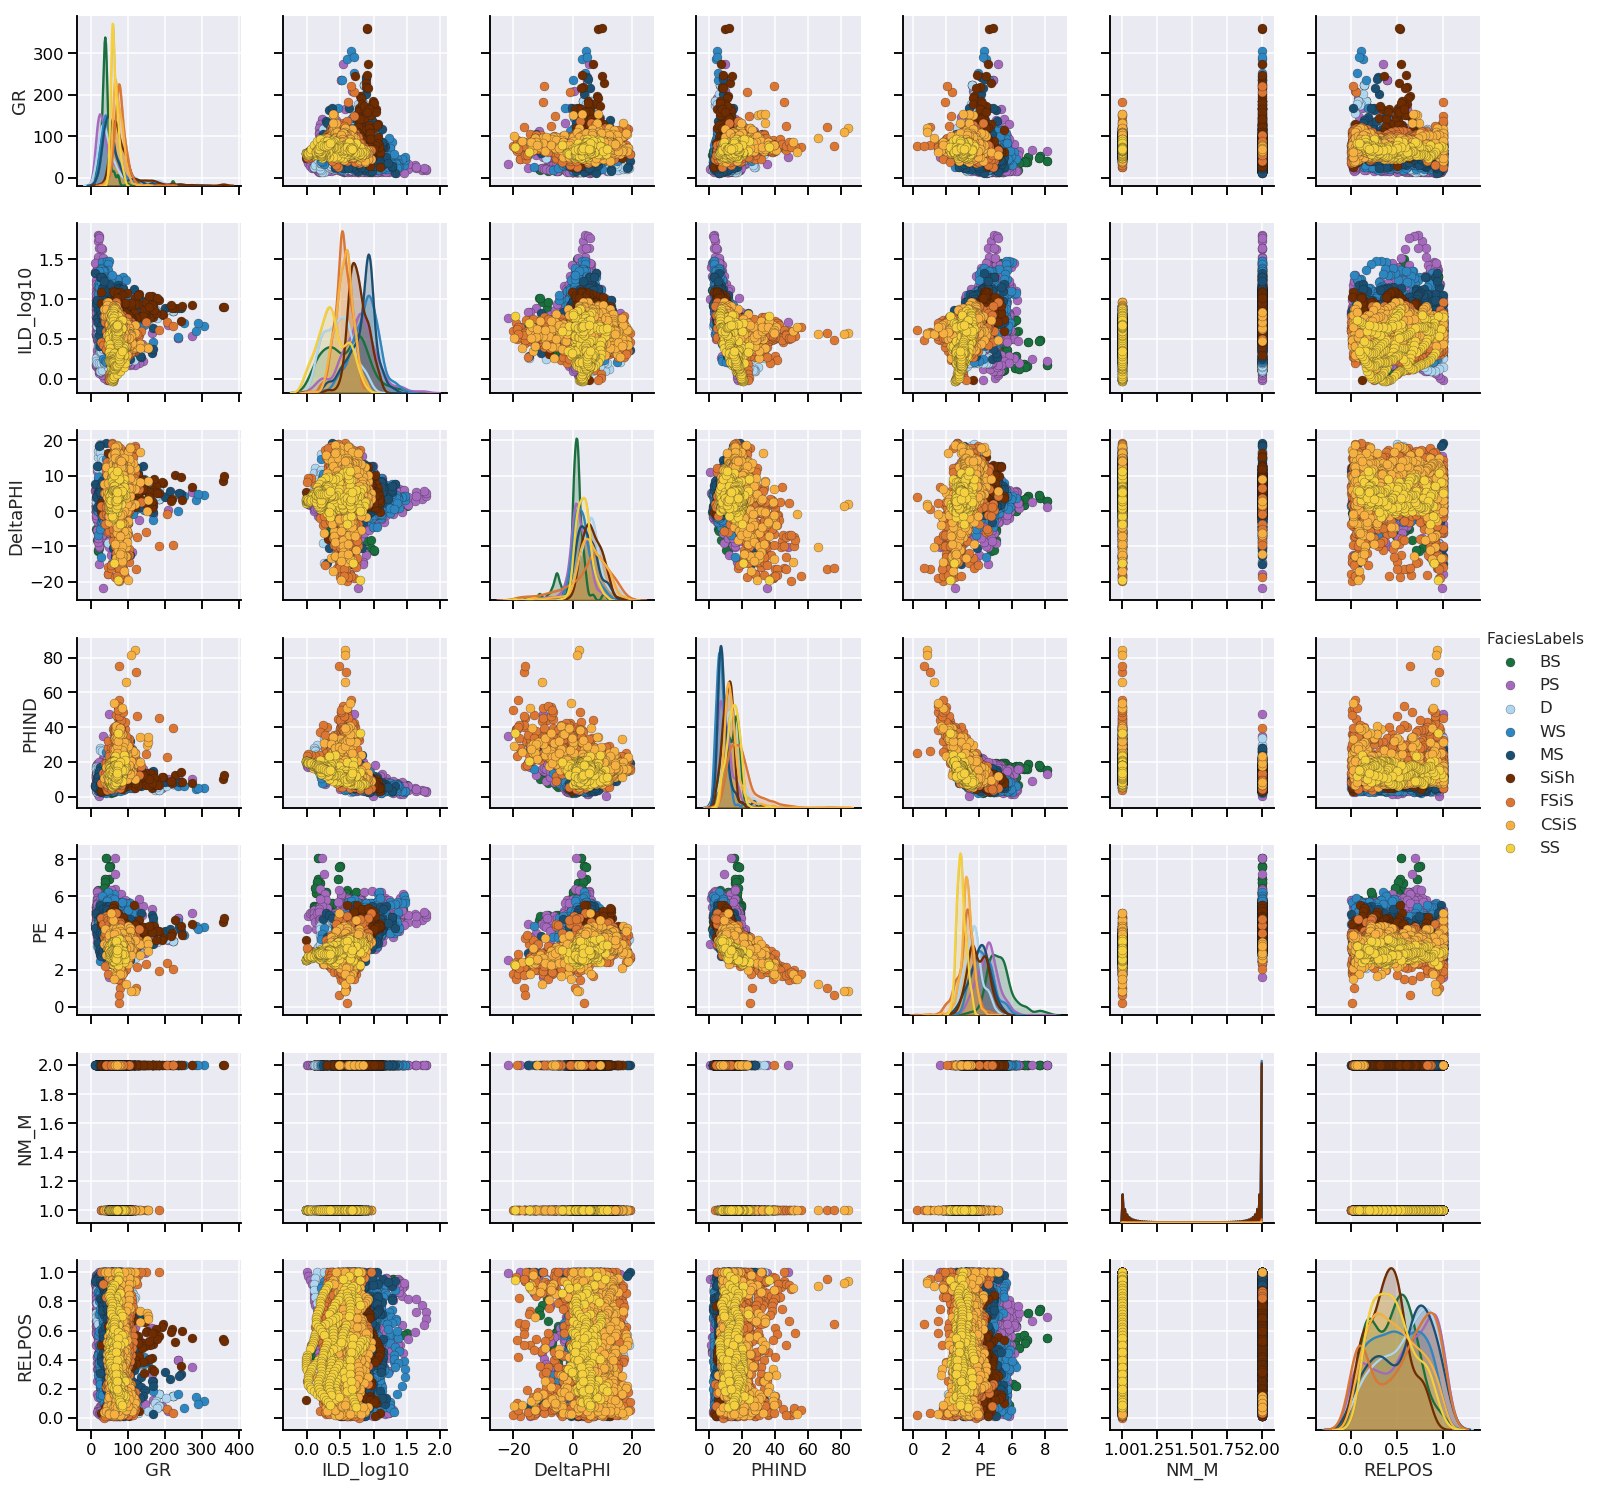

In [7]:
#save plot display settings to change back to when done plotting with seaborn
inline_rc = dict(mpl.rcParams)

sns.set()
sns.set_context("talk", font_scale = 1.0)
sns.set_style({ 'axes.edgecolor': '0.0',
                'axes.grid': True,
                 'axes.spines.bottom': True,
                 'axes.spines.left': True,
                 'axes.spines.right': True,
                 'axes.spines.top': True,
                'patch.edgecolor': 'k',
                'patch.force_edgecolor': True,
                 'xtick.bottom': True,
 'xtick.color': '0.0',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': '0.0',
 'ytick.direction': 'out',
 'ytick.left': True,
 'ytick.right': False})
sns.pairplot(all_data.drop(['Well Name','Facies','Formation','Depth'],axis=1),
             hue='FaciesLabels', palette=facies_color_map, plot_kws=dict(edgecolor="k", linewidth=0.25),
             hue_order=list(reversed(facies_labels)), height = 3)
#plt.savefig("Figures/Figure2.png", dpi = 1000)

#switch back to default matplotlib plot style
mpl.rcParams.update(inline_rc)

# Splitting the data based on the NM_M indicator

* The objective function for ssGMM does not converge when the NM_M indicator is used as a feature/variable (see Part II), and so the solution (as discussed in Section 4.1 of our paper) is to break the dataset into two separate datasets based on the NM_M indicator.

In [8]:
all_data_feature_vectors = all_data.drop(['Formation', 'Well Name', 'Depth','Facies','NM_M','FaciesLabels'], axis=1)
scaler = RobustScaler(quantile_range=(25.0, 75.0), with_centering=True, with_scaling=True).fit(all_data_feature_vectors)

### Non-marine data (NM_M = 1)
* We filter the dataset by the NM_M value of 1 and this gives us all the data that corresponds to NM = 1
* There is a strong correlation (~99%) between NM = 1 and non-marine facies (Classes 1-3), but this relationship is not perfect due to human error near the interfaces of different classes (i.e. the 31 points belonging to Classes 4-8).

In [9]:
filter1 = all_data['NM_M'] == 1
NM_data = all_data[filter1]
NM_data['Facies'].value_counts()

2    934
3    764
1    268
8     12
5     11
4      5
6      2
7      1
Name: Facies, dtype: int64

In [10]:
## Isolating the KIMZEY well for training
NM_train_data = NM_data[(NM_data['Well Name'] == 'KIMZEY A')]

## The remaining wells are used for testing
NM_test_data = NM_data[NM_data['Well Name'] != 'KIMZEY A']

In [11]:
# This indicates that the NM dataset only contains NM classes
NM_train_data['Facies'].value_counts()

2    85
3    74
1     9
Name: Facies, dtype: int64

In [12]:
## We use an individual scalar for the non-marine and marine datasets
NM_data_X = NM_data.drop(['Formation', 'Well Name', 'Depth','Facies','NM_M','FaciesLabels'], axis=1)
scaler_NM = RobustScaler(quantile_range=(25.0, 75.0), with_centering=True,with_scaling=True).fit(NM_data_X)

#Training data
NM_train_data_y = NM_train_data['Facies'].values
NM_train_data_X = NM_train_data.drop(['Formation', 'Well Name', 'Depth','Facies','NM_M','FaciesLabels'], axis=1)
NM_train_data_X = scaler_NM.transform(NM_train_data_X)

#Testing data
NM_test_data_y = NM_test_data['Facies'].values
NM_test_data_X = NM_test_data.drop(['Formation', 'Well Name', 'Depth','Facies','NM_M','FaciesLabels'], axis=1)
NM_test_data_X = scaler_NM.transform(NM_test_data_X)

### Marine data (NM_M = 2)
* We filter the dataset by the NM_M value of 2 and this gives us all the data that corresponds to NM = 2
* There is a strong correlation (~99%) between M = 2 and marine facies (Classes 4-9), but this relationship is not perfect due to human error near the interfaces of different classes (i.e. the 22 points beloning to Classes 2 and 3).

In [13]:
filter2 = all_data['NM_M'] == 2
M_data = all_data[filter2]
M_data['Facies'].value_counts()

8    674
6    580
5    285
4    266
9    173
7    140
3     16
2      6
Name: Facies, dtype: int64

In [14]:
## Isolating the KIMZEY well for training
M_train_data = M_data[(M_data['Well Name'] == 'KIMZEY A')]

## The remaining wells are used for testing
M_test_data = M_data[M_data['Well Name'] != 'KIMZEY A']

In [15]:
# This indicates that the M dataset only contains M classes
M_train_data['Facies'].value_counts()

8    90
5    53
6    51
4    43
7    27
9     7
Name: Facies, dtype: int64

In [16]:
M_data_X = M_data.drop(['Formation', 'Well Name', 'Depth','Facies','NM_M','FaciesLabels'], axis=1)
scaler_M = RobustScaler(quantile_range=(25.0, 75.0), with_centering=True,with_scaling=True).fit(M_data_X)

#Training data
M_train_data_y = M_train_data['Facies'].values
M_train_data_X = M_train_data.drop(['Formation', 'Well Name', 'Depth','Facies','NM_M','FaciesLabels'], axis=1)
M_train_data_X = scaler_M.transform(M_train_data_X)

#Testing data
M_test_data_y = M_test_data['Facies'].values
M_test_data_X = M_test_data.drop(['Formation', 'Well Name', 'Depth','Facies','NM_M','FaciesLabels'], axis=1)
M_test_data_X = scaler_M.transform(M_test_data_X)

### Plotting the training and testing data distributions
* The plots below show the number of data points for each of the nine classes for both the training (1 well) and the testing (9 wells) data.
* The first figure represents **Figure 3(a)**
* The second figure represents **Figure 3(b)**

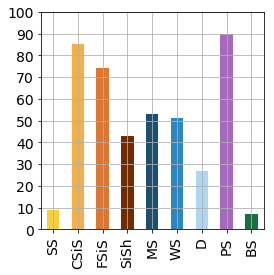

In [17]:
train_data_facies_counts = pd.concat([NM_train_data['Facies'].value_counts().sort_index(),M_train_data['Facies'].value_counts().sort_index()])
train_data_facies_counts.index = facies_labels
train_data_facies_counts.plot(kind='bar',color=facies_colors, grid = True, ylim = {0,100}, yticks = np.linspace(0,100,11), fontsize = 14, figsize = [4,4])
#plt.savefig("Figures/Figure3a.png",bbox_inches="tight", dpi = 800)

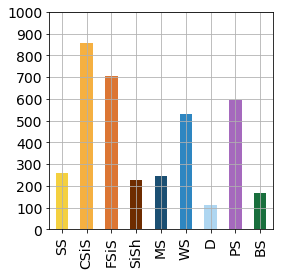

In [18]:
test_data = all_data[all_data['Well Name'] != 'KIMZEY A']
test_data_facies_counts = test_data['Facies'].value_counts().sort_index()
test_data_facies_counts.index = facies_labels
test_data_facies_counts.plot(kind='bar',color=facies_colors, ylim = {0,1000}, grid = True, yticks = np.linspace(0,1000,11), fontsize = 14, figsize = [4,4])
#plt.savefig("Figures/Figure3b.png", bbox_inches="tight",dpi = 800)

# Well log classification with *supervised methods*
* To assess if the ssGMM method can outperform supervised methods in the context a small training dataset on our well log classification scenario, we need supervised methods to serve as a basis of comparison.
* We consider a Gaussian Naive Bayes (GNB) classifier and XGBoost [(Chen and Guestrin, 2016)](http://doi.acm.org/10.1145/2939672.2939785) as our supervised methods
* [GNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) is implemented using a class from scikit-learn
* XGBoost is not contained in scikit-learn, and must be downloaded separately. Details for installing XGBoost are given on their website (https://xgboost.readthedocs.io/en/latest/build.html)

A function that computes the adjacent facies classification metric (taken from [Hall, 2016](https://doi.org/10.1190/tle35100906.1))

In [19]:
adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])
def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

### Gaussian Naive Bayes
* The results below correspond to the GNB entry in **Table 2**.

In [20]:
from sklearn.naive_bayes import GaussianNB

from datetime import datetime
start_time = datetime.now()

gnb = GaussianNB(priors=None)
gnb.fit(NM_train_data_X, NM_train_data_y)
y_pred_gnb_NM = gnb.predict(NM_test_data_X)
gnb_initial_accuracy = accuracy_score(NM_test_data_y, y_pred_gnb_NM)
print("Accuracy of Bayes classifier on non-marine data: ", gnb_initial_accuracy)
gnb.fit(M_train_data_X, M_train_data_y)
y_pred_gnb_M = gnb.predict(M_test_data_X)
gnb_initial_accuracy = accuracy_score(M_test_data_y, y_pred_gnb_M)
print("Accuracy of Bayes classifier on marine data: ", gnb_initial_accuracy)

gnb_overall_acc = accuracy_score(np.concatenate((NM_test_data_y, M_test_data_y), axis=0), np.concatenate((y_pred_gnb_NM, y_pred_gnb_M)))
print("Overall accuracy of Bayes classifier: ", gnb_overall_acc)
cv_conf = confusion_matrix(np.concatenate((NM_test_data_y, M_test_data_y)), np.concatenate((y_pred_gnb_NM, y_pred_gnb_M)))
print("Adjacent facies classification accuracy = %.4f" % accuracy_adjacent(cv_conf, adjacent_facies))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

print(classification_report(np.concatenate((NM_test_data_y, M_test_data_y)), np.concatenate((y_pred_gnb_NM, y_pred_gnb_M)), digits = 4))

Accuracy of Bayes classifier on non-marine data:  0.4920721705850191
Accuracy of Bayes classifier on marine data:  0.32263242375601925
Overall accuracy of Bayes classifier:  0.4064359113034072
Adjacent facies classification accuracy = 0.8259
Duration: 0:00:00.149009
              precision    recall  f1-score   support

           1     0.2951    0.0695    0.1125       259
           2     0.6644    0.3474    0.4562       855
           3     0.4428    0.8286    0.5772       706
           4     0.4444    0.1053    0.1702       228
           5     0.1100    0.1399    0.1232       243
           6     0.3571    0.1036    0.1606       531
           7     0.2188    0.5526    0.3134       114
           8     0.4011    0.7114    0.5130       596
           9     0.4286    0.0181    0.0347       166

   micro avg     0.4064    0.4064    0.4064      3698
   macro avg     0.3736    0.3196    0.2734      3698
weighted avg     0.4354    0.4064    0.3591      3698



### Extreme Gradient Boost classifier (XGB)

In [21]:
from xgboost import XGBClassifier

In [22]:
## This is here to show the BEST that XGB can do on the testing data

def XGB_NM(l_rate, m_depth, min_child, estimators):
    XGB = XGBClassifier(learning_rate = l_rate, max_depth = m_depth, min_child_weight = min_child, n_estimators = estimators)
    XGB.fit(NM_train_data_X, NM_train_data_y)
    y_pred_XGB_NM = XGB.predict(NM_test_data_X)    
    return accuracy_score(NM_test_data_y, y_pred_XGB_NM), [l_rate, m_depth, min_child, estimators]

def XGB_M(l_rate, m_depth, min_child, estimators):
    XGB = XGBClassifier(learning_rate = l_rate, max_depth = m_depth, min_child_weight = min_child, n_estimators = estimators)
    XGB.fit(M_train_data_X, M_train_data_y)
    y_pred_XGB_M = XGB.predict(M_test_data_X)    
    return accuracy_score(M_test_data_y, y_pred_XGB_M), [l_rate, m_depth, min_child, estimators]

# These are the hyper-parameters we consider for XGB, as well as their range of values
l_rate = [.10, .11, .12, .13, .14]
m_depth = [2, 3, 5, 7]
min_child = [6, 7, 8, 10, 12]
estimators = [50, 75, 100, 125, 150, 175, 200]

XGB_results_NM = Parallel(n_jobs=num_cores, verbose=1)(delayed(XGB_NM)(l_rate = i, m_depth = j, min_child = k, estimators = l) for i in l_rate for j in m_depth for k in min_child for l in estimators)
XGB_results_M = Parallel(n_jobs=num_cores, verbose=1)(delayed(XGB_M)(l_rate = i, m_depth = j, min_child = k, estimators = l) for i in l_rate for j in m_depth for k in min_child for l in estimators)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   27.6s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:   38.6s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 504 tasks      | elapsed:   29.0s
[Parallel(n_jobs=4)]: Done 700 out of 700 | elapsed:   40.5s finished


The results in the two cells below indicate the best achievable accuracy for the non-marine and marine datasets, respectively, as well as the corresponding XGB model. These accuracies are reported in **Table 2** as the XGB (best) entry.

In [23]:
XGB_NM_max = 0
for i in range(len(XGB_results_NM)):
    if XGB_results_NM[i][0] > XGB_NM_max:
        XGB_NM_max = XGB_results_NM[i][0]
        NM_index = i
print(XGB_results_NM[NM_index])

(0.5691634773100055, [0.12, 5, 6, 75])


In [24]:
XGB_M_max = 0
for i in range(len(XGB_results_M)):
    if XGB_results_M[i][0] > XGB_M_max:
        XGB_M_max = XGB_results_M[i][0]
        M_index = i
print(XGB_results_M[M_index])

(0.38148742643124667, [0.1, 2, 12, 50])


The model selection scheme is currently set to the 5-fold, 5-repeated (ALPHA = 1.0) setting from the paper (i.e. the best model recovered for XGB). This XGB model is used to produce the subseqent confusion matrices and well prediction plots (Figures 9-11), but the current XGB model can be commented out and one of the other two models can be uncommented to reproduce the results in Tables 2 and 3 associated with them.

For the current XGB model setting, the output of the cell below should correspond the the XGB* entry in **Table 3**.

In [25]:
from datetime import datetime
start_time = datetime.now()

# if alpha = 1, this is represents the standard model selection procedure that only leverages the cross-validation means for selecting a model
# if alpha = 0.5, this corresponds to the SMSD model selection approach that produces a score that simultaneously uses the mean and std. dev. cross-validation scores (with equal contribution)
def SMSD_calc_XGB(CV_means, CV_stdvs, alpha, XGB_param_dict):
    #### This is Equation 11 in the C&G publication ####
    SMSD = alpha*((CV_means - np.min(CV_means))/(np.max(CV_means) - np.min(CV_means))) + (1-alpha)*((np.max(CV_stdvs) - CV_stdvs)/(np.max(CV_stdvs) - np.min(CV_stdvs)))
    
    #### STEP 1 - Determine the indices of the CV iterables that have the highest SMSD value (there may be more that one!) ####
    SMSD_filter = np.argwhere(SMSD >= np.max(SMSD))
    print("The highest SMSD value is: ", np.max(SMSD), " with ", len(SMSD_filter)-1, " conflicts")
    print("The parameter combination(s) for the CV iterables with the highest SMSD value")
    for i in range(len(SMSD_filter)):
        print("SMSD = %0.6f for %r" % (SMSD[SMSD_filter][i], XGB_param_dict[np.asscalar(SMSD_filter[i])]))

    #### STEP 2 - Determine the model with the least model complexity if there is a conflict above ####
    SMSD_index = np.asscalar(SMSD_filter[0])
    print("The best parameter combination using SMSD with the least complicated model is: ")
    print("SMSD = %0.6f for %r" % (SMSD[SMSD_index], XGB_param_dict[SMSD_index]))
    
    return XGB_param_dict[SMSD_index]

###############################################################################################################################
##########################                    Model Selection Scheme                              #############################
###############################################################################################################################

##### 3-fold #####
#n_folds = 3
#cv_repeats = 1
#ALPHA = 1.0
#skf = StratifiedKFold(n_splits=n_folds, shuffle = False, random_state = 10)

##### 5-fold #####
#n_folds = 5
#cv_repeats = 1
#ALPHA = 0.5
#skf = StratifiedKFold(n_splits=n_folds, shuffle = False, random_state = 10)

##### 5-fold, 5-repeated #####
n_folds = 5
cv_repeats = 5
ALPHA = 1.0
skf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats = cv_repeats, random_state = 10) 


# Hyper-parameter combinations for XGB = 700
XGB_parameters = {'learning_rate': [.10, .11, .12, .13, .14], 'max_depth': [2, 3, 5, 7], 'min_child_weight': [6, 7, 8, 10, 12], 'n_estimators': [50, 75, 100, 125, 150, 175, 200]}

#############################################
####   Non-marine data model selection   ####
#############################################
XGB_NM = GridSearchCV(XGBClassifier(), XGB_parameters, cv = skf, scoring='accuracy', n_jobs = -1, verbose = 1)    
XGB_NM.fit(NM_train_data_X, NM_train_data_y)
XGB_means_NM = XGB_NM.cv_results_['mean_test_score']
XGB_stds_NM = XGB_NM.cv_results_['std_test_score']
XGB_NM_params = SMSD_calc_XGB(CV_means = XGB_means_NM, CV_stdvs = XGB_stds_NM, alpha = ALPHA, XGB_param_dict = XGB_NM.cv_results_['params'])

#########################################
####   Marine data model selection   ####
#########################################
XGB_M = GridSearchCV(XGBClassifier(), XGB_parameters, cv = skf, scoring='accuracy', n_jobs = -1, verbose = 1)    
XGB_M.fit(M_train_data_X, M_train_data_y)
XGB_means_M = XGB_M.cv_results_['mean_test_score']
XGB_stds_M = XGB_M.cv_results_['std_test_score']
XGB_M_params = SMSD_calc_XGB(CV_means = XGB_means_M, CV_stdvs = XGB_stds_M, alpha = ALPHA, XGB_param_dict = XGB_M.cv_results_['params'])

#################################
#### Testing data performance ###
#################################
XGB_NM = XGBClassifier(learning_rate = XGB_NM_params['learning_rate'], max_depth = XGB_NM_params['max_depth'], min_child_weight = XGB_NM_params['min_child_weight'], n_estimators = XGB_NM_params['n_estimators'])
XGB_NM.fit(NM_train_data_X, NM_train_data_y)
y_pred_XGB_NM = XGB_NM.predict(NM_test_data_X)
XGB_NM_accuracy = accuracy_score(NM_test_data_y, y_pred_XGB_NM)
XGB_NM_f1_accuracy = f1_score(NM_test_data_y, y_pred_XGB_NM, average = 'weighted')
print("Accuracy of XGB classifier when training on non-marine data ", + XGB_NM_accuracy)

XGB_M = XGBClassifier(learning_rate = XGB_M_params['learning_rate'], max_depth = XGB_M_params['max_depth'], min_child_weight = XGB_M_params['min_child_weight'], n_estimators = XGB_M_params['n_estimators'])
XGB_M.fit(M_train_data_X, M_train_data_y)
y_pred_XGB_M = XGB_M.predict(M_test_data_X)
XGB_M_accuracy = accuracy_score(M_test_data_y, y_pred_XGB_M)
XGB_M_f1_accuracy = f1_score(M_test_data_y, y_pred_XGB_M, average = 'weighted')
print("Accuracy of XGB classifier when training on non-marine data ", + XGB_M_accuracy)

#### Overall accuracies ####
XGB_overall_acc = accuracy_score(np.concatenate((NM_test_data_y, M_test_data_y), axis=0), np.concatenate((y_pred_XGB_NM, y_pred_XGB_M)))
XGB_f1_overall_acc = f1_score(np.concatenate((NM_test_data_y, M_test_data_y), axis=0), np.concatenate((y_pred_XGB_NM, y_pred_XGB_M)), average = 'weighted')
print("Overall accuracy of XGB classifier: ", XGB_overall_acc)
print("Overall F1-accuracy of XGB classifier: ", XGB_f1_overall_acc)
cv_conf_XGB = confusion_matrix(np.concatenate((NM_test_data_y, M_test_data_y)), np.concatenate((y_pred_XGB_NM, y_pred_XGB_M)))
print("Adjacent facies classification accuracy = %.4f" % accuracy_adjacent(cv_conf_XGB, adjacent_facies))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Fitting 25 folds for each of 700 candidates, totalling 17500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 345 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 845 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1545 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2445 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3545 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4845 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 6345 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 8045 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 9945 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 12045 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 14345 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 16845 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 17493 out of 17500 | elapsed: 12.1min remaining:    0.2s
[Parallel(n_jobs=-1)

The highest SMSD value is:  1.0  with  2  conflicts
The parameter combination(s) for the CV iterables with the highest SMSD value
SMSD = 1.000000 for {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 75}
SMSD = 1.000000 for {'learning_rate': 0.12, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 150}
SMSD = 1.000000 for {'learning_rate': 0.12, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 125}
The best parameter combination using SMSD with the least complicated model is: 
SMSD = 1.000000 for {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 75}
Fitting 25 folds for each of 700 candidates, totalling 17500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 11242 tasks      |

The highest SMSD value is:  1.0  with  0  conflicts
The parameter combination(s) for the CV iterables with the highest SMSD value
SMSD = 1.000000 for {'learning_rate': 0.11, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 75}
The best parameter combination using SMSD with the least complicated model is: 
SMSD = 1.000000 for {'learning_rate': 0.11, 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 75}
Accuracy of XGB classifier when training on non-marine data  0.5527610716238381
Accuracy of XGB classifier when training on non-marine data  0.3477795612627073
Overall accuracy of XGB classifier:  0.44916170903190916
Overall F1-accuracy of XGB classifier:  0.4263062503681972
Adjacent facies classification accuracy = 0.8364
Duration: 0:35:28.506724


C:\Users\mwdunham\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\mwdunham\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Well log classification with *ssGMM*

Loading the ssGMM code

In [26]:
import sys
sys.path.append('../ssGMM_code/')
from ssGMM import ss_GaussianMixtureModels

In [27]:
## Defining the parameter grid for ssGMM
B = np.linspace(0.10,0.90,17) #Beta
T = np.logspace(-3,0,31) #Tolerance

### Testing data performance
* The figures below give the performance of ssGMM on the testing data (9 wells) for each hyper-parameter combination
* This helps determine the maximum achievable accuracy on both the non-marine and marine datasets and where we ultimately want our ssMM models to end up in the parameter space.
* Since ssGMM only has two hyper-parameter, we are able to easily visualize this in 2D. We could not do the same for XGB because we implemented XGB with four hyper-parameters (i.e. no easy way to visualize 4D)

In [28]:
def ssGMM_NM_test(B, T):
    ssGMM_NM_output = ss_GaussianMixtureModels(NM_train_data_X, NM_train_data_y, NM_test_data_X, NM_test_data_y, beta = B, tol = T, max_iterations = 100, early_stop = 'True')     
    return accuracy_score(NM_test_data_y, ssGMM_NM_output[0])

results = Parallel(n_jobs=num_cores, verbose=1)(delayed(ssGMM_NM_test)(B = i, T = j) for i in B for j in T)
results = np.array(results)
accuracy_2D_NM = np.reshape(results, (len(B),len(T)))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   42.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  6.3min
[Parallel(n_jobs=4)]: Done 527 out of 527 | elapsed:  7.2min finished


This is **Figure 5(a)** - testing data performance for the non-marine subset

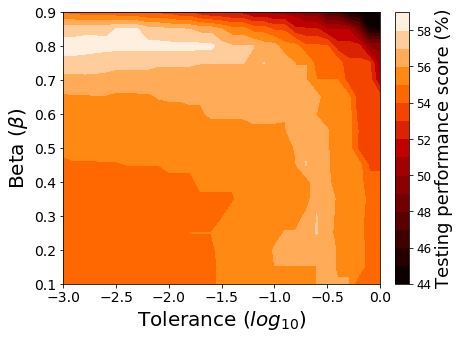

In [30]:
levs = 100*np.linspace(0.44,0.59,16)
plt.contourf(np.log10(T), B, 100*accuracy_2D_NM, levels = levs)
plt.ylabel(r'Beta ($\beta$)', fontsize = 20)
plt.xlabel('Tolerance ($log_{10}$)', fontsize = 20)
plt.xlim([-3,0])
plt.tick_params(labelsize = 14)
cbar = plt.colorbar(pad = 0.04)
cbar.ax.set_ylabel('Testing performance score (%)', fontsize = 18)
cbar.ax.tick_params(labelsize = 12)
plt.rcParams['image.cmap'] = 'gist_heat'
plt.rcParams["figure.figsize"] = [7,5]
#plt.savefig("Figures/Figure5a.png", bbox_inches="tight", dpi = 600)

In [31]:
def ssGMM_M_test(B, T):
    ssGMM_M_output = ss_GaussianMixtureModels(M_train_data_X, M_train_data_y, M_test_data_X, M_test_data_y, beta = B, tol = T, max_iterations = 100, early_stop = 'True')     
    return accuracy_score(M_test_data_y, ssGMM_M_output[0])

results = Parallel(n_jobs=num_cores, verbose=1)(delayed(ssGMM_M_test)(B = i, T = j) for i in B for j in T)
results = np.array(results)
accuracy_2D_M = np.reshape(results, (len(B),len(T)))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  9.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 18.6min
[Parallel(n_jobs=4)]: Done 527 out of 527 | elapsed: 20.1min finished


This is **Figure 5(b)** - testing data performance for the marine subset

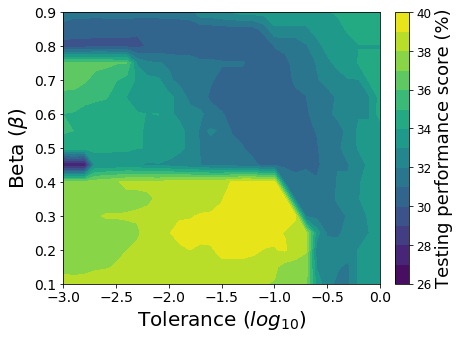

In [33]:
levs = 100*np.linspace(0.26,0.40,15)
plt.contourf(np.log10(T), B, 100*accuracy_2D_M, levels = levs)
plt.ylabel(r'Beta ($\beta$)', fontsize = 20)
plt.xlabel('Tolerance ($log_{10}$)', fontsize = 20)
plt.xlim([-3,0])
plt.tick_params(labelsize = 14)
cbar = plt.colorbar(pad = 0.04)
cbar.ax.set_ylabel('Testing performance score (%)', fontsize = 18)
cbar.ax.tick_params(labelsize = 12)
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams["figure.figsize"] = [7,5]
#plt.savefig("Figures/Figure5b.png", bbox_inches="tight", dpi = 600)

* This gives the maximum achievable accuracies for ssGMM on both the non-marine and the marine datasets
* These values correspond to the 'ssGMM (best)' entry in **Table 2**

In [34]:
print(np.argwhere(accuracy_2D_NM>= np.max(accuracy_2D_NM)))
print('The maximum accuracy for the non-marine data is: ', 100*accuracy_2D_NM[14,3] ,', and occurs at:')
print('Beta = : ', B[14])
print('Tolerance = : ', T[3])

[[14  0]
 [14  1]
 [14  2]
 [14  3]]
The maximum accuracy for the non-marine data is:  58.392564242755604 , and occurs at:
Beta = :  0.8
Tolerance = :  0.001995262314968879


In [35]:
print(np.argwhere(accuracy_2D_M>= np.max(accuracy_2D_M)))
print(np.max(accuracy_2D_M))
print('The maximum accuracy for the marine data is: ', 100*accuracy_2D_M[4,19] ,', and occurs at:')
print('Beta = : ', B[4])
print('Tolerance = : ', T[19])

[[ 4 19]]
0.39593365436062067
The maximum accuracy for the marine data is:  39.593365436062065 , and occurs at:
Beta = :  0.30000000000000004
Tolerance = :  0.07943282347242818


## Grid search and model selection for ssGMM

### ssGMM model complexity
* First, we establish the model complexity for ssGMM
* With regards to tolerance, we do not want the algorithm to run too long, or too short, so we consider a central tolerance for the values we've considered to be preferred
* With regards to beta, it seems intuitive to weight the unlabeled and labeled portions of the objective function equally (i.e. beta = 0.5). So, we prefer values of beta = 0.5, and values that deviate from 0.5 are considered more complex
* The figure below (**Figure 1**) depicts the ssGMM model complexity with the 'least complicated model' in the center of the grid

In [36]:
B = np.linspace(0.10,0.90,17)
T = np.logspace(-3,0,31)
B_avg = (np.max(B) + np.min(B))/2
ssGMM_param_dict = []
mc = []
for i in range(len(B)):
    for j in range(len(T)):
        model_complexity = (abs(B[i] - B_avg)/(np.max(B) - np.min(B)))*100 + (abs(j - ((len(T)-1)/2))/(len(T)-1))*100
        mc.append(model_complexity)
        ssGMM_param_dict.append({'Beta': np.around(B[i], 2), 'Tolerance': np.around(T[j], 5), 'Model complexity': np.int(model_complexity)})

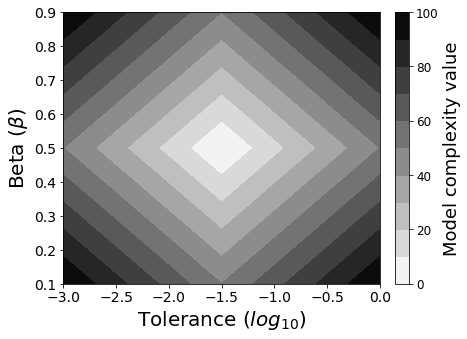

In [38]:
levs = np.linspace(0,100,11)
plt.contourf(np.log10(T), B, np.reshape(mc, (len(B),len(T))), levels = levs)
plt.ylabel(r'Beta ($\beta$)', fontsize = 20)
plt.xlabel('Tolerance ($log_{10}$)', fontsize = 20)
plt.tick_params(labelsize = 14)
cbar = plt.colorbar(pad = 0.04)
cbar.ax.set_ylabel('Model complexity value', fontsize = 18)
cbar.ax.tick_params(labelsize = 12)
plt.rcParams['image.cmap'] = 'gist_gray_r'
plt.rcParams["figure.figsize"] = [7,5]
#plt.savefig("Figures/Figure1.png", bbox_inches="tight", dpi = 600)

The ssGMM code does not interface with scikit-learn, so running the cross-validation in parallel must be done from scratch. Doing so is trivial (see below), but the packages in the cell below are required to do so.

In [39]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

The model selection scheme is currently set to the 5-fold, 5-repeated (ALPHA = 0.5) setting from the paper (the best model recovered for ssGMM). This ssGMM model is used to produce the subseqent confusion matrices and well prediction plots (Figures 9-11), but the current ssGMM model can be commented out and one of the other two models can be uncommented to reproduce the results in Tables 2 and 3 associated with them.

For the current ssGMM model setting, the output of the cell below should correspond the the ssGMM (SMSD)* entry in **Table 3**.

In [40]:
B = np.linspace(0.10,0.90,17)
T = np.logspace(-3,0,31)

from datetime import datetime
start_time = datetime.now()

###############################################################################################################################
##########################                           FUNCTIONS                                    #############################
###############################################################################################################################

def ssGMM_NM(B, T, train_index, test_index):
    ssGMM_NM_output = ss_GaussianMixtureModels(NM_train_data_X[train_index], NM_train_data_y[train_index], NM_train_data_X[test_index], NM_train_data_y[test_index], beta = B, tol = T, max_iterations = 100, early_stop = 'True') 
    return accuracy_score(NM_train_data_y[test_index], ssGMM_NM_output[0])

def ssGMM_M(B, T, train_index, test_index):
    ssGMM_M_output = ss_GaussianMixtureModels(M_train_data_X[train_index], M_train_data_y[train_index], M_train_data_X[test_index], M_train_data_y[test_index], beta = B, tol = T, max_iterations = 100, early_stop = 'True') 
    return accuracy_score(M_train_data_y[test_index], ssGMM_M_output[0])

# if alpha = 1, this is represents the standard model selection procedure that only leverages the cross-validation means for selecting a model
# if alpha = 0.5, this corresponds to the SMSD model selection approach that produces a score that simultaneously uses the mean and std. dev. cross-validation scores (with equal contribution)
def SMSD_calc(CV_means, CV_stdvs, alpha, ssGMM_param_dict):
    #### This is Equation 11 in the C&G publication ####
    SMSD = alpha*((CV_means - np.min(CV_means))/(np.max(CV_means) - np.min(CV_means))) + (1-alpha)*((np.max(CV_stdvs) - CV_stdvs)/(np.max(CV_stdvs) - np.min(CV_stdvs)))
    
    #### STEP 1 - Determine the indices of the CV iterables that have the highest SMSD value (there may be more that one!) ####
    SMSD_filter = np.ndarray.flatten(np.argwhere(SMSD >= np.max(SMSD)))
    print("The highest SMSD value is: ", np.max(SMSD), " with ", len(SMSD_filter)-1, " conflicts")
    print("The parameter combination(s) for the CV iterables with the highest SMSD value")
    for i in range(len(SMSD_filter)):
        print("SMSD = %0.6f for %r" % (SMSD[SMSD_filter][i], ssGMM_param_dict[np.asscalar(SMSD_filter[i])]))
    
    #### STEP 2 - Determine the model with the least model complexity if there is a conflict above ####
    min_mc = 101
    for i in range(len(SMSD_filter)):
        current_mc = ssGMM_param_dict[np.asscalar(SMSD_filter[i])]['Model complexity']
        if current_mc < min_mc:
            min_mc_index = i
            min_mc = current_mc
    print()
    print("The best parameter combination using SMSD with the least complicated model is: ")
    print("SMSD = %0.6f for %r" % (SMSD[SMSD_filter[min_mc_index]], ssGMM_param_dict[np.asscalar(SMSD_filter[min_mc_index])]))
    
    return SMSD, ssGMM_param_dict[np.asscalar(SMSD_filter[min_mc_index])]['Beta'], ssGMM_param_dict[np.asscalar(SMSD_filter[min_mc_index])]['Tolerance']


###############################################################################################################################
##########################                    Model Selection Scheme                              #############################
###############################################################################################################################

##### 3-fold #####
#n_folds = 3
#cv_repeats = 1
#ALPHA = 1.0
#skf = StratifiedKFold(n_splits=n_folds, shuffle = False, random_state = 10)

##### 5-fold #####
#n_folds = 5
#cv_repeats = 1
#ALPHA = 0.5
#skf = StratifiedKFold(n_splits=n_folds, shuffle = False, random_state = 10)

##### 5-fold, 5-repeated #####
n_folds = 5
cv_repeats = 5
ALPHA = 0.5
skf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats = cv_repeats, random_state = 10) 

#############################################
####   Non-marine data model selection   ####
#############################################
results = Parallel(n_jobs=num_cores, verbose=1)(delayed(ssGMM_NM)(B = i, T = j, train_index = k, test_index = l) for i in B for j in T for k, l in skf.split(NM_train_data_X, NM_train_data_y))
means_1D_NM = []
stdvs_1D_NM = []
for i in range(np.int_(len(results)/(n_folds*cv_repeats))):
    means_1D_NM.append(np.mean(results[n_folds*cv_repeats*i : n_folds*cv_repeats*i + n_folds*cv_repeats]))
    stdvs_1D_NM.append(np.std(results[n_folds*cv_repeats*i : n_folds*cv_repeats*i + n_folds*cv_repeats]))
means_1D_NM = np.array(means_1D_NM)
stdvs_1D_NM = np.array(stdvs_1D_NM)
ssGMM_SMSD_NM_1D, NM_beta, NM_tol = SMSD_calc(CV_means = means_1D_NM, CV_stdvs = stdvs_1D_NM, alpha = ALPHA, ssGMM_param_dict = ssGMM_param_dict)

#########################################
####   Marine data model selection   ####
#########################################
results = Parallel(n_jobs=num_cores, verbose=1)(delayed(ssGMM_M)(B = i, T = j, train_index = k, test_index = l) for i in B for j in T for k, l in skf.split(M_train_data_X, M_train_data_y))
means_1D_M = []
stdvs_1D_M = []
for i in range(np.int_(len(results)/(n_folds*cv_repeats))):
    means_1D_M.append(np.mean(results[n_folds*cv_repeats*i : n_folds*cv_repeats*i + n_folds*cv_repeats]))
    stdvs_1D_M.append(np.std(results[n_folds*cv_repeats*i : n_folds*cv_repeats*i + n_folds*cv_repeats]))
means_1D_M = np.array(means_1D_M)
stdvs_1D_M = np.array(stdvs_1D_M)
ssGMM_SMSD_M_1D, M_beta, M_tol = SMSD_calc(CV_means = means_1D_M, CV_stdvs = stdvs_1D_M, alpha = ALPHA, ssGMM_param_dict = ssGMM_param_dict)

#### Applying model to testing data ####
ssGMM_NM = ss_GaussianMixtureModels(NM_train_data_X, NM_train_data_y, NM_test_data_X, NM_test_data_y, beta = NM_beta, tol = NM_tol, max_iterations = 50, early_stop = 'True')
ssGMM_M = ss_GaussianMixtureModels(M_train_data_X, M_train_data_y, M_test_data_X, M_test_data_y, beta = M_beta, tol = M_tol, max_iterations = 50, early_stop = 'True')

#### Testing data accuracies ####
print('Non-marine data classification accuracy = %.4f' % accuracy_score(NM_test_data_y, ssGMM_NM[0]))
print('Marine data classification accuracy = %.4f' % accuracy_score(M_test_data_y, ssGMM_M[0]))
cv_conf_ssGMM = confusion_matrix(np.concatenate((NM_test_data_y, M_test_data_y)), np.concatenate((ssGMM_NM[0], ssGMM_M[0])))
print('Total classification accuracy = %.4f' % accuracy_score(np.concatenate((NM_test_data_y, M_test_data_y)), np.concatenate((ssGMM_NM[0], ssGMM_M[0]))))
print('F-1 score = %.4f' % f1_score(np.concatenate((NM_test_data_y, M_test_data_y)), np.concatenate((ssGMM_NM[0], ssGMM_M[0])), average = 'weighted'))
print("Adjacent facies classification accuracy = %.4f" % accuracy_adjacent(cv_conf_ssGMM, adjacent_facies))

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 297 tasks      | elapsed:   13.7s
[Parallel(n_jobs=4)]: Done 797 tasks      | elapsed:   22.7s
[Parallel(n_jobs=4)]: Done 1503 tasks      | elapsed:   36.4s
[Parallel(n_jobs=4)]: Done 3303 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 5503 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 8103 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done 12899 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done 13175 out of 13175 | elapsed:  3.0min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


The highest SMSD value is:  0.7857897178707876  with  8  conflicts
The parameter combination(s) for the CV iterables with the highest SMSD value
SMSD = 0.785790 for {'Beta': 0.8, 'Tolerance': 0.001, 'Model complexity': 87}
SMSD = 0.785790 for {'Beta': 0.8, 'Tolerance': 0.00126, 'Model complexity': 84}
SMSD = 0.785790 for {'Beta': 0.8, 'Tolerance': 0.00158, 'Model complexity': 80}
SMSD = 0.785790 for {'Beta': 0.8, 'Tolerance': 0.002, 'Model complexity': 77}
SMSD = 0.785790 for {'Beta': 0.8, 'Tolerance': 0.00251, 'Model complexity': 74}
SMSD = 0.785790 for {'Beta': 0.8, 'Tolerance': 0.00316, 'Model complexity': 70}
SMSD = 0.785790 for {'Beta': 0.8, 'Tolerance': 0.00398, 'Model complexity': 67}
SMSD = 0.785790 for {'Beta': 0.8, 'Tolerance': 0.00501, 'Model complexity': 64}
SMSD = 0.785790 for {'Beta': 0.8, 'Tolerance': 0.00631, 'Model complexity': 60}

The best parameter combination using SMSD with the least complicated model is: 
SMSD = 0.785790 for {'Beta': 0.8, 'Tolerance': 0.00631, 'M

[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.7s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   26.3s
[Parallel(n_jobs=4)]: Done 876 tasks      | elapsed:   49.0s
[Parallel(n_jobs=4)]: Done 1576 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 2476 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 3576 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done 4876 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 6376 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 8076 tasks      | elapsed:  4.6min
[Parallel(n_jobs=4)]: Done 9976 tasks      | elapsed:  5.3min
[Parallel(n_jobs=4)]: Done 12076 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done 13168 out of 13175 | elapsed:  6.6min remaining:    0.1s
[Parallel(n_jobs=4)]: Done 13175 out of 13175 | elapsed:  6.6min finished


The highest SMSD value is:  0.6648769420643084  with  0  conflicts
The parameter combination(s) for the CV iterables with the highest SMSD value
SMSD = 0.664877 for {'Beta': 0.4, 'Tolerance': 0.00794, 'Model complexity': 32}

The best parameter combination using SMSD with the least complicated model is: 
SMSD = 0.664877 for {'Beta': 0.4, 'Tolerance': 0.00794, 'Model complexity': 32}
Number of labeled data: 168
Number of unlabeled data: 1829
The number of iterations used:  23
The objective function: 
 [-6303.690707453349, -3121.7824166070955, -3089.7526547234265, -3067.506454891308, -3055.928998055967, -3050.308436901243, -3047.1441219378326, -3045.037058145454, -3043.4668601864523, -3042.212065409288, -3041.156261629352, -3040.2221532331223, -3039.3425958494768, -3038.435035669896, -3037.3494050434374, -3035.690760756749, -3031.9489281756905, -3020.1566752873005, -3002.402168279992, -2996.563216504073, -2994.5635916601905, -2993.665676617237, -2993.4045624072955, -2993.334469045658]
St

C:\Users\mwdunham\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


If the model selection scheme of 5-fold, 5-repeated (ALPHA = 0.5) is used above, then all the figures below pertain to those in **Figure 8**.

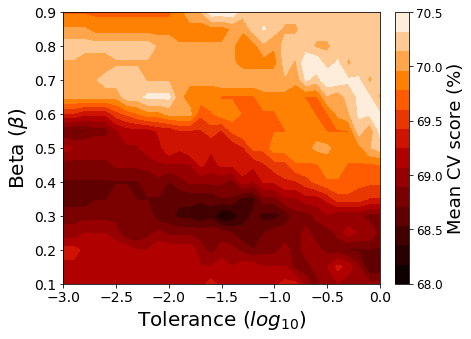

In [42]:
levs = 100*np.linspace(0.68,0.705,15)
plt.contourf(np.log10(T), B, 100*np.reshape(means_1D_NM, (len(B),len(T))), levels = levs)
plt.ylabel(r'Beta ($\beta$)', fontsize = 20)
plt.xlabel('Tolerance ($log_{10}$)', fontsize = 20)
plt.tick_params(labelsize = 14)
cbar = plt.colorbar(pad = 0.04, ticks = 100*np.linspace(0.68,0.705,6))
cbar.ax.set_ylabel('Mean CV score (%)', fontsize = 18)
cbar.ax.tick_params(labelsize = 12)
plt.rcParams['image.cmap'] = 'gist_heat'
plt.rcParams["figure.figsize"] = [7,5]
#plt.savefig("Figures/Figure8a.png", bbox_inches="tight", dpi = 600)

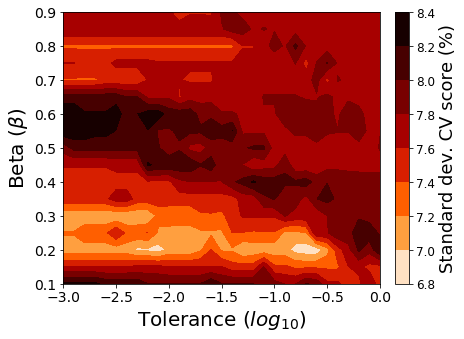

In [44]:
levs = 100*np.linspace(0.068,0.084,9)
plt.contourf(np.log10(T), B, 100*np.reshape(stdvs_1D_NM, (len(B),len(T))), levels = levs)
plt.ylabel(r'Beta ($\beta$)', fontsize = 20)
plt.xlabel('Tolerance ($log_{10}$)', fontsize = 20)
plt.tick_params(labelsize = 14)
cbar = plt.colorbar(pad = 0.04)
cbar.ax.set_ylabel('Standard dev. CV score (%)', fontsize = 18)
cbar.ax.tick_params(labelsize = 12)
plt.rcParams['image.cmap'] = 'gist_heat_r'
plt.rcParams["figure.figsize"] = [7,5]
#plt.savefig("Figures/Figure8b.png", bbox_inches="tight", dpi = 600)

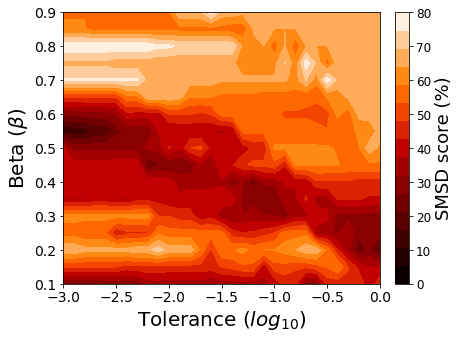

In [46]:
levs = 100*np.linspace(0.0,0.80,16)
plt.contourf(np.log10(T), B, 100*np.reshape(ssGMM_SMSD_NM_1D, (len(B),len(T))), levels = levs)
plt.ylabel(r'Beta ($\beta$)', fontsize = 20)
plt.xlabel('Tolerance ($log_{10}$)', fontsize = 20)
plt.tick_params(labelsize = 14)
cbar = plt.colorbar(pad = 0.04, ticks = 100*np.linspace(0.0,0.80,9))
cbar.ax.set_ylabel('SMSD score (%)', fontsize = 18)
cbar.ax.tick_params(labelsize = 12)
plt.rcParams['image.cmap'] = 'gist_heat'
plt.rcParams["figure.figsize"] = [7,5]
#plt.savefig("Figures/Figure8c.png", bbox_inches="tight", dpi = 600)

In [47]:
### Marine data ###

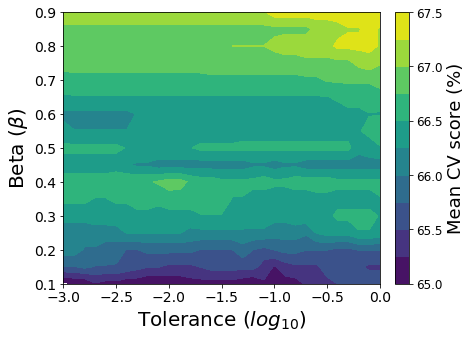

In [49]:
levs = 100*np.linspace(0.65,0.675,11)
plt.contourf(np.log10(T), B, 100*np.reshape(means_1D_M, (len(B),len(T))), levels = levs)
plt.ylabel(r'Beta ($\beta$)', fontsize = 20)
plt.xlabel('Tolerance ($log_{10}$)', fontsize = 20)
plt.tick_params(labelsize = 14)
cbar = plt.colorbar(pad = 0.04, ticks = 100*np.linspace(0.65,0.675,6))
cbar.ax.set_ylabel('Mean CV score (%)', fontsize = 18)
cbar.ax.tick_params(labelsize = 12)
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams["figure.figsize"] = [7,5]
#plt.savefig("Figures/Figure8d.png", bbox_inches="tight", dpi = 600)

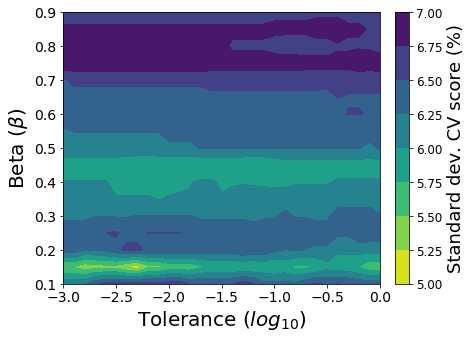

In [51]:
levs = 100*np.linspace(0.05,0.07,9)
plt.contourf(np.log10(T), B, 100*np.reshape(stdvs_1D_M, (len(B),len(T))), levels = levs)
plt.ylabel(r'Beta ($\beta$)', fontsize = 20)
plt.xlabel('Tolerance ($log_{10}$)', fontsize = 20)
plt.tick_params(labelsize = 14)
cbar = plt.colorbar(pad = 0.04, ticks = 100*np.linspace(0.05,0.07,9))
cbar.ax.set_ylabel('Standard dev. CV score (%)', fontsize = 18)
cbar.ax.tick_params(labelsize = 12)
plt.rcParams['image.cmap'] = 'viridis_r'
plt.rcParams["figure.figsize"] = [7,5]
#plt.savefig("Figures/Figure8e.png", bbox_inches="tight", dpi = 600)

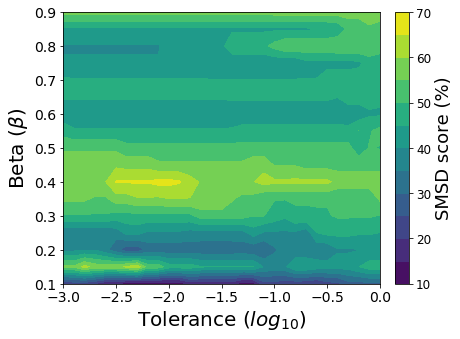

In [53]:
levs = 100*np.linspace(0.10,0.70,13)
plt.contourf(np.log10(T), B, 100*np.reshape(ssGMM_SMSD_M_1D, (len(B),len(T))), levels = levs)
plt.ylabel(r'Beta ($\beta$)', fontsize = 20)
plt.xlabel('Tolerance ($log_{10}$)', fontsize = 20)
plt.tick_params(labelsize = 14)
cbar = plt.colorbar(pad = 0.04)
cbar.ax.set_ylabel('SMSD score (%)', fontsize = 18)
cbar.ax.tick_params(labelsize = 12)
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams["figure.figsize"] = [7,5]
#plt.savefig("Figures/Figure8f.png", bbox_inches="tight", dpi = 600)

# Interpretation of results

### Confusion matrices
* The function below is used to plot a confusion matrix and the matrices below (if the cells above are unchanged) represent the confusion matrices depicted in **Figure 11**.

In [54]:
from itertools import product

def plot_confusion_matrix(cm, classes, normalize=False, cmap=plt.cm.coolwarm, saveTitle = 'confusion_matrix.png'):
    """
    This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    cm = cm*100
    cm = cm.astype('int')

    im = plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin = 0, vmax = 100)
    cbar = plt.colorbar(ticks = np.linspace(0,100,11), pad = 0.04)
    cbar.ax.set_ylabel('Classification value (%)', fontsize = 22)
    cbar.ax.tick_params(labelsize = 16)
    tick_marks = np.arange(len(classes))
    
    ax = plt.gca();

    # Major ticks
    ax.set_xticks(tick_marks);
    ax.set_yticks(tick_marks);

    # Labels for major ticks
    ax.set_xticklabels(classes, fontsize = 18);
    ax.set_yticklabels(classes, fontsize = 18);

    # Minor ticks
    ax.set_xticks(np.arange(-.5, len(classes), 1), minor=True);
    ax.set_yticks(np.arange(-.5, len(classes), 1), minor=True);
    
    # Gridlines based on minor ticks
    ax.grid(which='minor', color='k', linestyle='-', linewidth=2)

    plt.rcParams["figure.figsize"] = [7,5]
    plt.ylabel('True label', fontsize = 26)
    plt.xlabel('Predicted label', fontsize = 26)
    #plt.savefig(saveTitle, bbox_inches="tight", dpi = 600)

XGB confusion matrix - **Figure 11(a)**

Normalized confusion matrix


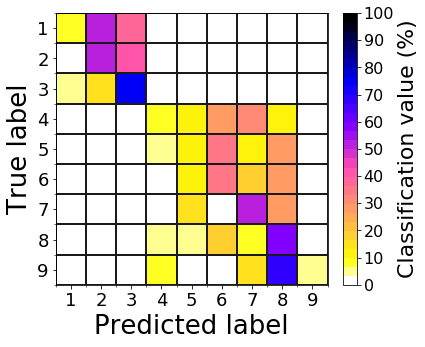

In [70]:
## Confusion matrices
plot_confusion_matrix(cv_conf_XGB, np.int_(np.linspace(1,9,9)), normalize=True, cmap=plt.get_cmap('gnuplot2_r', 30), saveTitle = 'Figures/Figure11a.png')

ssGMM confusion matrix - **Figure 11b**

Normalized confusion matrix


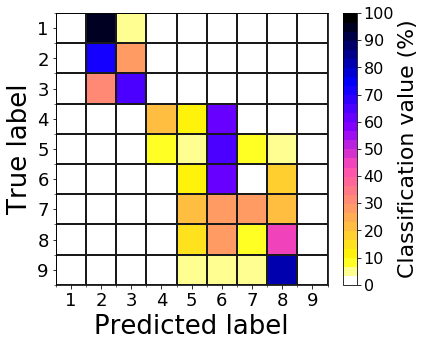

In [55]:
#ssGMM confusion matrix
plot_confusion_matrix(cv_conf_ssGMM, np.int_(np.linspace(1,9,9)), normalize=True, cmap=plt.get_cmap('gnuplot2_r', 30), saveTitle = 'Figures/Figure11b.png')

### Facies comparisons

The original dataframe (for reference)

In [72]:
all_data

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS
...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,MS


The ssGMM prediction probabilities for the unlabeled wells (see **Equation 9**)

In [73]:
ssGMM_NM_prob = []
for i in range(len(ssGMM_NM[1])):
    ssGMM_NM_prob.append(100*ssGMM_NM[1][i,:].max())
ssGMM_M_prob = []
for i in range(len(ssGMM_M[1])):
    ssGMM_M_prob.append(100*ssGMM_M[1][i,:].max())

A copy of the original dataframe is made, and then the XGB and ssGMM predictions are added to the dataframe, as well as the ssGMM prediction probabilities.

In [74]:
#XGB prediction
all_data_with_preds = pd.DataFrame.copy(all_data)
all_data_with_preds['XGB'] = pd.Series(np.int_(np.concatenate((NM_train_data_y,y_pred_XGB_NM, M_train_data_y,y_pred_XGB_M),axis = 0)), index = np.concatenate((NM_train_data.index, NM_test_data.index, M_train_data.index, M_test_data.index),axis = 0))
all_data_with_preds['ssGMM'] = pd.Series(np.int_(np.concatenate((NM_train_data_y,ssGMM_NM[0], M_train_data_y,ssGMM_M[0]),axis = 0)), index = np.concatenate((NM_train_data.index, NM_test_data.index, M_train_data.index, M_test_data.index),axis = 0))
all_data_with_preds['Probability'] = pd.Series((np.concatenate((np.ones(len(NM_train_data_y)), ssGMM_NM_prob, np.ones(len(M_train_data_y)), ssGMM_M_prob),axis = 0)), index = np.concatenate((NM_train_data.index, NM_test_data.index, M_train_data.index, M_test_data.index),axis = 0))

In [75]:
all_data_with_preds

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS,FaciesLabels,XGB,ssGMM,Probability
0,3,A1 SH,SHRIMPLIN,2793.0,77.450,0.664,9.900,11.915,4.600,1,1.000,FSiS,3,3,99.996853
1,3,A1 SH,SHRIMPLIN,2793.5,78.260,0.661,14.200,12.565,4.100,1,0.979,FSiS,3,3,81.544605
2,3,A1 SH,SHRIMPLIN,2794.0,79.050,0.658,14.800,13.050,3.600,1,0.957,FSiS,3,2,80.048037
3,3,A1 SH,SHRIMPLIN,2794.5,86.100,0.655,13.900,13.115,3.500,1,0.936,FSiS,3,2,86.706466
4,3,A1 SH,SHRIMPLIN,2795.0,74.580,0.647,13.500,13.300,3.400,1,0.915,FSiS,3,2,87.819266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4144,5,C LM,CHURCHMAN BIBLE,3120.5,46.719,0.947,1.828,7.254,3.617,2,0.685,MS,6,6,96.131835
4145,5,C LM,CHURCHMAN BIBLE,3121.0,44.563,0.953,2.241,8.013,3.344,2,0.677,MS,8,6,91.352576
4146,5,C LM,CHURCHMAN BIBLE,3121.5,49.719,0.964,2.925,8.013,3.190,2,0.669,MS,8,6,90.697887
4147,5,C LM,CHURCHMAN BIBLE,3122.0,51.469,0.965,3.083,7.708,3.152,2,0.661,MS,8,6,89.809003


This is a well viewer that is modified from the Jupyter-notebook code (Facies_classification.ipynb) provided by [Hall (2016)](https://doi.org/10.1190/tle35100906.1) on their [github repository](https://github.com/seg/2016-ml-contest) to plot, for a given well, the five log values for reference, the true lithofacies, the XGB prediction, the ssGMM prediction, and the ssGMM prediction probabilities.

In [83]:
def compare_facies_only_plot(logs, compadre, compadre2, facies_colors, figure_name):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=0.001*(logs.Depth.min()); zbot=0.001*(logs.Depth.max())
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    cluster3 = np.repeat(np.expand_dims(logs[compadre2].values,1), 100, 1)

    f, ax = plt.subplots(nrows=1, ncols=9, figsize=(12, 6))
    ax[0].plot(logs.GR, 0.001*logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, 0.001*logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, 0.001*logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, 0.001*logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, 0.001*logs.Depth, '-', color='black')
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im3 = ax[7].imshow(cluster3, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    ax[8].plot(logs['Probability'].values, 0.001*logs.Depth, '-', color='black')

    for i in range(len(ax)-4):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    ax[8].set_ylim(ztop,zbot)
    ax[8].invert_yaxis()
    ax[8].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('True Facies')
    ax[6].set_xlabel(compadre)
    ax[7].set_xlabel(compadre2)
    ax[8].set_xlabel('Probability (%)')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([]); ax[4].set_yticklabels([])
    ax[5].set_yticklabels([]); ax[6].set_yticklabels([]); ax[7].set_yticklabels([]); ax[8].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    ax[7].set_xticklabels([])
    #plt.savefig(figure_name, bbox_inches="tight", dpi = 1000)

Since only one well can be viewed at a time, switch the 'Well Name' below from 'SHANKLE' below to any of the 9 other wells.
* If 'Well Name' == 'SHANKLE', the well viewer below will represent **Figure 9**
* If 'Well Name' == 'NOLAN', the well viewer below will represent **Figure 10**

In [84]:
print("The names of all 10 wells:")
print(all_data_with_preds['Well Name'].unique())

The names of all 10 wells:
[SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, KIMZEY A, CROSS H CATTLE, NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]
Categories (10, object): [SHRIMPLIN, ALEXANDER D, SHANKLE, LUKE G U, ..., NOLAN, Recruit F9, NEWBY, CHURCHMAN BIBLE]


In [85]:
ONEWELL_data = all_data_with_preds[all_data_with_preds['Well Name'] == 'SHANKLE']
#ONEWELL_data = all_data_with_preds[all_data_with_preds['Well Name'] == 'NOLAN']

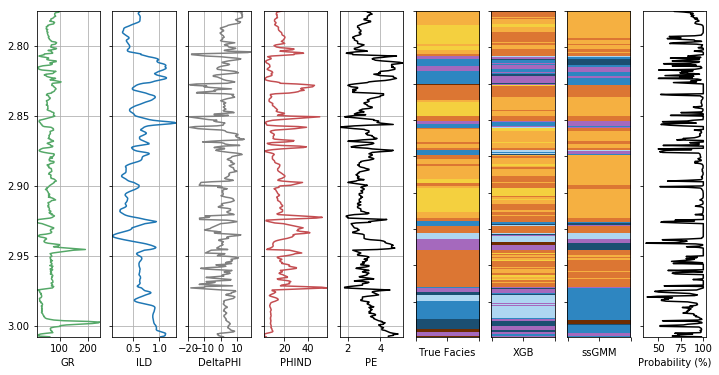

In [86]:
compare_facies_only_plot(ONEWELL_data, 'XGB', 'ssGMM', facies_colors, "Figures/Figure9")
#compare_facies_only_plot(ONEWELL_data, 'XGB', 'ssGMM', facies_colors, "Figures/Figure10")

### Prediction accuracies for individual wells
* This subsection computes the information presented in **Table 4**
* Currently, 'ONEWELL_data' is set to 'SHANKLE', so the two cells below report the first row of **Table 4**
* To reproduce the individual accuracies for the other wells, change the 'Well Name' in 'ONEWELL_data' to the desired well

In [87]:
## XGB prediction on the one well
print('Total classification accuracy for XGB = %.4f' % accuracy_score(ONEWELL_data['XGB'].values, ONEWELL_data['Facies'].values))
print(classification_report(ONEWELL_data['XGB'].values, ONEWELL_data['Facies'].values, digits = 4))

Total classification accuracy for XGB = 0.4477
              precision    recall  f1-score   support

           1     0.1685    0.3846    0.2344        39
           2     0.5730    0.4397    0.4976       116
           3     0.6410    0.5319    0.5814       141
           4     0.0000    0.0000    0.0000         5
           5     0.4211    0.3636    0.3902        22
           6     0.2254    0.6154    0.3299        26
           7     0.8235    0.3043    0.4444        46
           8     0.5500    0.4074    0.4681        54

   micro avg     0.4477    0.4477    0.4477       449
   macro avg     0.4253    0.3809    0.3683       449
weighted avg     0.5482    0.4477    0.4715       449



In [88]:
## ssGMM prediction on the one well
print('Total classification accuracy for ssGMM = %.4f' % accuracy_score(ONEWELL_data['ssGMM'].values, ONEWELL_data['Facies'].values))
print(classification_report(ONEWELL_data['ssGMM'].values, ONEWELL_data['Facies'].values, digits = 4))

Total classification accuracy for ssGMM = 0.5278
              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         0
           2     0.8427    0.4098    0.5515       183
           3     0.7949    0.8230    0.8087       113
           4     0.0000    0.0000    0.0000         6
           5     0.0526    0.0476    0.0500        21
           6     0.5915    0.5385    0.5638        78
           7     0.4706    0.6154    0.5333        13
           8     0.4500    0.5143    0.4800        35

   micro avg     0.5278    0.5278    0.5278       449
   macro avg     0.4003    0.3686    0.3734       449
weighted avg     0.6974    0.5278    0.5814       449



C:\Users\mwdunham\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\mwdunham\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\mwdunham\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
